In [25]:
import bayes3d as b
import jax.numpy as jnp
import jax
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7049/static/


In [3]:

intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=50.0, fy=50.0,
    cx=50.0, cy=50.0,
    near=0.001, far=16.0
)
from bayes3d.rendering.nvdiffrast_jax.jax_renderer import Renderer as JaxRenderer
jax_renderer = JaxRenderer(intrinsics)


In [11]:

import trimesh
def as_mesh(scene_or_mesh):
    """
    Convert a possible scene to a mesh.

    If conversion occurs, the returned mesh has only vertex and face data.
    """
    if isinstance(scene_or_mesh, trimesh.Scene):
        if len(scene_or_mesh.geometry) == 0:
            mesh = None  # empty scene
        else:
            # we lose texture information here
            mesh = trimesh.util.concatenate(
                tuple(trimesh.Trimesh(vertices=g.vertices, faces=g.faces)
                    for g in scene_or_mesh.geometry.values()))
    else:
        assert(isinstance(mesh, trimesh.Trimesh))
        mesh = scene_or_mesh
    return mesh
mesh  =as_mesh(trimesh.load('InteriorTest.obj'))
mesh.vertices  = mesh.vertices * jnp.array([1.0, -1.0, 1.0]) + jnp.array([0.0, 1.0, 0.0])
vertices = mesh.vertices
faces = mesh.faces
print(b.utils.aabb(mesh.vertices))
b.show_trimesh("1",mesh)

(Array([5.190015, 3.000812, 8.171652], dtype=float32), Array([[ 1.        ,  0.        ,  0.        , -0.09099948],
       [ 0.        ,  1.        ,  0.        , -0.49959397],
       [ 0.        ,  0.        ,  1.        , -0.01582694],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],      dtype=float32))


In [50]:
def apply_move(pose, move):
    if move == "ahead":
        return pose @ b.transform_from_pos(jnp.array([0.0, 0.0, 0.1]))
    elif move == "right":
        return pose @ b.transform_from_pos(jnp.array([0.1, 0.0, 0.0]))
    elif move == "left":
        return pose @ b.transform_from_pos(jnp.array([-0.1, 0.0, 0.0]))
    elif move == "rotate_left":
        return pose @ b.transform_from_axis_angle(jnp.array([-0.0, 1.0, 0.0]), jnp.deg2rad(10.0) * -1.0)
    elif move == "rotate_right":
        return pose @ b.transform_from_axis_angle(jnp.array([-0.0, 1.0, 0.0]), jnp.deg2rad(10.0) * 1.0)
moves = [*["ahead" for _ in range(20)], *["rotate_left" for _ in range(8)], *["ahead" for _ in range(10)], *["rotate_right" for _ in range(4)],*["ahead" for _ in range(10)]]
camera_poses = [jnp.eye(4)]
for move in moves:
    camera_poses.append(apply_move(camera_poses[-1], move))
camera_poses = jnp.stack(camera_poses)

In [36]:
gt_images = [
    jax_renderer.render(vertices, faces, b.inverse_pose(p), intrinsics)[0][0,...]
    for p in camera_poses
]
b.make_gif_from_pil_images([b.get_depth_image(img, min_val=0.0, max_val=5.0, remove_max=False) for img in gt_images], "gt.gif")

In [28]:
def loss(trans, q, gt_img):
    camera_pose = b.translation_and_quaternion_to_pose_matrix(trans, q)
    img = jax_renderer.render(vertices, faces, b.inverse_pose(camera_pose), intrinsics)[0][0,...]
    return (jnp.abs(img - gt_img)).mean()

value_and_grad_jit = jax.jit(jax.value_and_grad(loss, argnums=(0,1,)))

In [29]:
b.clear()
b.show_pose("actual", camera_poses[1])
tr,q = b.pose_matrix_to_translation_and_quaternion(camera_poses[0])
b.show_pose("inferred", b.translation_and_quaternion_to_pose_matrix(tr,q), size=0.1)

In [30]:
print("start " , value_and_grad_jit(tr, q, gt_images[1]))
poses = []
pbar = tqdm(range(200))
timestep = 1
for _  in pbar:
    loss, (g1, g2) = value_and_grad_jit(tr, q, gt_images[timestep])
    tr -= g1 * 0.01
    q -= g2 * 0.01
    pbar.set_description(f"{loss}")
    # poses.append(b.translation_and_quaternion_to_pose_matrix(tr,q))
b.show_pose("inferred", b.translation_and_quaternion_to_pose_matrix(tr,q), size=0.1)

start  (Array(0.3906966, dtype=float32), (Array([ 0.05876064, -0.19676153, -0.34958   ], dtype=float32), Array([0.       , 1.6928822, 0.2993236, 0.7067344], dtype=float32)))


0.3322584927082062: 100%|██████████| 200/200 [00:00<00:00, 371.03it/s]  


In [31]:
b.clear()
b.show_pose("actual", camera_poses[1])
tr,q = b.pose_matrix_to_translation_and_quaternion(camera_poses[0])
b.show_pose("inferred", b.translation_and_quaternion_to_pose_matrix(tr,q), size=0.1)

In [32]:
inferred_poses = []
pbar2 = tqdm(range(len(gt_images)))
for timestep  in pbar2:
    pbar = tqdm(range(200))
    for _  in pbar:
        loss, (g1, g2) = value_and_grad_jit(tr, q, gt_images[timestep])
        tr -= g1 * 0.01
        q -= g2 * 0.01
        pbar.set_description(f"{loss}")
    b.show_pose("actual", camera_poses[timestep])
    b.show_pose("inferred", b.translation_and_quaternion_to_pose_matrix(tr,q), size=0.1)
    inferred_poses.append(b.translation_and_quaternion_to_pose_matrix(tr,q))

100%|██████████| 39/39 [00:29<00:00,  1.31it/s]


In [37]:
b.clear()
b.show_cloud("1", mesh.vertices)

In [55]:
camera_poses[22]

Array([[ 0.93969256,  0.        , -0.34202012,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.34202012,  0.        ,  0.93969256,  2.0000002 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],      dtype=float32)

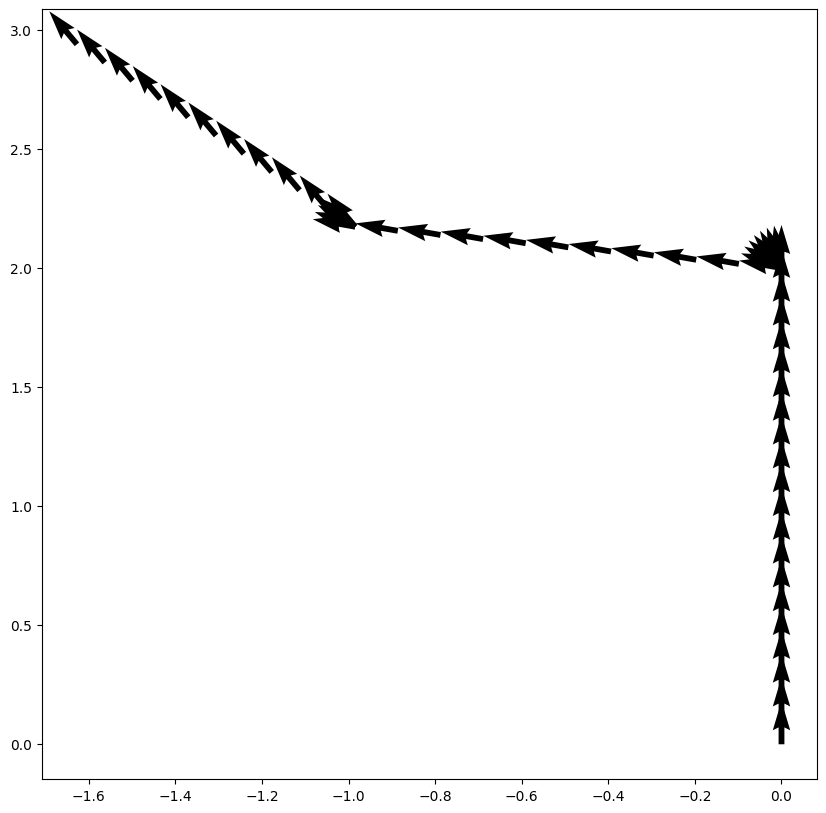

In [57]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.quiver(camera_poses[:,0,3], camera_poses[:,2,3], camera_poses[:,0,2], camera_poses[:,2,2])

In [80]:
b.clear()
for i in range(len(poses)):
    b.show_pose(f"{i}", poses[i])
    b.show_pose(f"{i}_actual", camera_poses[i])

In [ ]:
b.show_pose("2", b.translation_and_quaternion_to_pose_matrix(tr,q), size=0.1)


In [56]:

# b.show_pose("2", 

In [18]:
value_and_grad_jit(*b.pose_matrix_to_translation_and_quaternion(camera_poses[0]), gt_images[1])

(Array(0.43455184, dtype=float32),
 (Array([-0.15023103, -0.33511856,  0.05152562], dtype=float32),
  Array([ 0.        ,  1.6910034 , -0.15435895,  0.6346966 ], dtype=float32)))

In [5]:
translation_deltas = b.utils.make_translation_grid_enumeration(-0.2, -0.2, -0.2, 0.2, 0.2, 0.2, 25, 25, 25)
rotation_deltas = jax.vmap(lambda key: b.distributions.gaussian_vmf_zero_mean(key, 0.0001, 800.0))(
    jax.random.split(jax.random.PRNGKey(30), 100)
)

In [6]:
def grid_and_select(current_pose, diffs, obs_img, variance):
    possible_poses = jnp.einsum("aij,jk->aik", diffs, current_pose)
    rendered_imgs = b.RENDERER.render_many(b.inverse_pose(possible_poses)[:,None,...], jnp.array([0]))[...,:3]
    scores = jax.vmap(b.threedp3_likelihood, in_axes=(None, 0, None, None))(obs_img, rendered_imgs, variance, 0.0)
    return possible_poses[jnp.argmax(scores)], scores.max()
grid_and_select_jit = jax.jit(grid_and_select)

In [33]:
T = 1
current_pose = camera_poses[0]
b.clear()
b.show_pose(f"current_pose", current_pose)
b.show_pose(f"ground_truth", camera_poses[T])

In [55]:
translation_deltas = b.utils.make_translation_grid_enumeration(-0.1, -0.1, -0.1, 0.1, 0.1, 0.1, 25, 25, 25)

In [53]:
translation_deltas = b.utils.make_translation_grid_enumeration(-0.05, -0.05, -0.05, 0.05, 0.05, 0.05, 25, 25, 25)

In [56]:
T = 1
b.clear()
current_pose,score = grid_and_select_jit(current_pose, translation_deltas, images[T], 0.02)
# current_pose,score = grid_and_select_jit(current_pose, rotation_deltas, images[T], 0.02)
print(score)
b.show_pose(f"current_pose", current_pose)
b.show_pose(f"ground_truth", camera_poses[T])

23.425


In [31]:
print(current_pose)
print(camera_poses[T])

[[ 1.0000000e+00  0.0000000e+00  0.0000000e+00  6.6666678e-02]
 [ 0.0000000e+00  1.0000000e+00  0.0000000e+00  1.8626451e-08]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00 -4.1666478e-03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
[[ 0.99950653  0.         -0.03141076  0.1       ]
 [ 0.          1.          0.          0.        ]
 [ 0.03141076  0.          0.99950653  0.        ]
 [ 0.          0.          0.          1.        ]]


In [29]:
b.threedp3_likelihood(images[T],images[T], 0.02, 0.0)

Array(50., dtype=float32)

In [52]:
b.make_gif_from_pil_images(viz_images, 'room.gif')


In [21]:
b.show_trimesh("1",b.RENDERER.meshes[0])

(11, 100, 100, 4)